## SMSG

Training a UNet model on our custom tiles dataset.
***

Import packages

In [ ]:
import pathlib
from ast import literal_eval
from typing import Any, Union, Tuple, List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from sklearn.model_selection import GroupKFold
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torchvision import transforms
from pytorch_lightning.callbacks import (EarlyStopping, ModelCheckpoint,
                                         LearningRateMonitor)
from torchmetrics import ConfusionMatrix
from pl_bolts.models.vision.unet import UNet

Define an experiment configuration

In [2]:
cfg = {
    "root_dir": pathlib.Path("/media/toshiba-hdd/mlfires/dataset/images",
                             "final_dataset_alltiles_ts32"),
    "ds_version": pathlib.Path("dataset_v1"),
    "n_splits": 3,  # Number of folds
    "expand_fires": False,  # Whether to expand each train fire pixel to augment fire patterns
    "batch_size": 32,
    "num_workers": 8,
    "num_classes": 3,  # 'Background' as 0, 'no-fire' as 1, 'fire' as 2
    "input_channels": 62,  # Number of features/channels saved in the tiles numpy arrays
    "ignore_index": -100,
    "lr": 0.001,  # Initial learning rate
    "patience": 10,  # Epochs patience for early stopping
    "max_epochs": 60,
    "monitor": "val_nh1",
    "mode": "max",
}

The `SemSegmentDataset` class inherits from `torch.utils.data.Dataset` to create a custom dataset for semantic segmentation. It loads pairs of images and masks, which are already saved to disk as *numpy* arrays.

The list of *features* that are loaded as image channels is thus predefined during saving the arrays. (TODO) We may want to pass a list of feature/channel indexes that we want to keep. Regarding target masks, nan values are already mapped to class 0 (background), 0 values to class 1 (no fire) and 1 values to class 2 (fire).

In [3]:
class SemSegmentDataset(data.Dataset):
    """Semantic Segmentation Dataset for image tiles."""

    def __init__(self, dataframe: pd.DataFrame, root_dir: Union[
        str, pathlib.Path], expand_fires: bool = False, transform:
                 transforms.Compose = None, target_transform:
                 transforms.Compose = None) -> None:
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.expand_fires = expand_fires
        self.transform, self.target_transform = transform, target_transform

    def __len__(self) -> int:
        return len(self.dataframe)

    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        filepath, coords = self.dataframe.loc[idx, "filepath"], \
            literal_eval(self.dataframe.loc[idx, "coords"])

        fname = f"{pathlib.Path(filepath).stem}_{coords[0]}_{coords[1]}"
        img = np.load(pathlib.Path(self.root_dir, "img", f"{fname}.npy"))
        mask = np.load(pathlib.Path(self.root_dir, "mask", f"{fname}.npy"))

        if self.expand_fires:
            kernel = np.ones((3, 3), np.uint8)
            mask_ = cv.dilate((mask > 1).astype("uint8"), kernel,
                              iterations=1)
            mask = np.where(mask == 0, 0, np.where(mask_ > 0, 2, mask))

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = torch.squeeze(self.target_transform(mask))

        return img, mask

Verifying that the `SemSegmentDataset` class is working as intended.

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
target_transform = transforms.Compose([transforms.ToTensor()])

test_dataset_ = SemSegmentDataset(
    pd.read_csv(pathlib.Path(cfg["ds_version"], "test_tiles.csv")), cfg[
        "root_dir"], expand_fires=False, transform=transform,
    target_transform=target_transform
)

img, mask = test_dataset_[0]

print("img shape:", img.shape, "mask shape:", mask.shape)
print("img min:", torch.min(img), "img max:", torch.max(img),
      "mask min:", torch.min(mask), "mask max:", torch.max(mask))

img shape: torch.Size([62, 32, 32]) mask shape: torch.Size([32, 32])
img min: tensor(-1., dtype=torch.float64) img max: tensor(1., dtype=torch.float64) mask min: tensor(0.) mask max: tensor(1.)


Checking class frequencies in training data in order to define class weights

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
target_transform = transforms.Compose([transforms.ToTensor()])

train_dataset_ = SemSegmentDataset(
    pd.read_csv(pathlib.Path(cfg["ds_version"], "train_tiles.csv")), cfg[
        "root_dir"], expand_fires=cfg["expand_fires"], transform=transform,
    target_transform=target_transform
)

train_dataloader_ = data.DataLoader(train_dataset_, batch_size=256)

class_counts_batches_ = []
for batch_idx, batch in enumerate(train_dataloader_):
    class_counts_batch = batch[1].long().unique(return_counts=True)
    class_counts_batches_.append(class_counts_batch[1])
    print(batch_idx, class_counts_batch[1])

class_counts_batches = torch.stack(class_counts_batches_)
class_weight = torch.sum(class_counts_batches) / torch.sum(
    class_counts_batches, dim=0)
print("\nInverse frequency of each class as class weights:\n\t",
      class_weight)

0 tensor([ 77876, 183280,    988])
1 tensor([ 80049, 180681,   1414])
2 tensor([ 81406, 179526,   1212])
3 tensor([ 78803, 181936,   1405])
4 tensor([ 81341, 180096,    707])
5 tensor([ 75533, 185644,    967])
6 tensor([ 77548, 183599,    997])
7 tensor([ 76875, 183957,   1312])
8 tensor([ 82116, 178851,   1177])
9 tensor([ 76655, 184383,   1106])
10 tensor([ 76082, 185211,    851])
11 tensor([ 82336, 178657,   1151])
12 tensor([ 81476, 179583,   1085])
13 tensor([ 3137, 11164,    35])

Inverse frequency of each class as class weights:
	 tensor([  3.3186,   1.4400, 237.5379])


A custom `pl.LightningDataModule` to manage the data processing setup for the experiments.

In [6]:
class SemSegmentDataModule(pl.LightningDataModule):
    """Semantic Segmentation DataModule for image tiles."""

    def __init__(self, dataframes: List[pd.DataFrame], root_dir: Union[
        str, pathlib.Path], expand_fires: bool = False, batch_size: int = 32,
                 num_workers: int = 0, **kwargs) -> None:
        super().__init__(**kwargs)

        self.train_df, self.val_df, self.test_df = dataframes
        self.root_dir = root_dir
        self.expand_fires = expand_fires
        self.batch_size, self.num_workers = batch_size, num_workers

        self.transform = transforms.Compose([transforms.ToTensor()])
        self.target_transform = transforms.Compose([transforms.ToTensor()])

    def prepare_data(self):
        pass

    def setup(self, stage: str = None) -> None:
        self.train_dataset = SemSegmentDataset(
            self.train_df, self.root_dir, expand_fires=self.expand_fires,
            transform=self.transform, target_transform=self.target_transform
        )
        self.val_dataset = SemSegmentDataset(
            self.val_df, self.root_dir, expand_fires=False,
            transform=self.transform, target_transform=self.target_transform
        )
        self.test_dataset = SemSegmentDataset(
            self.test_df, self.root_dir, expand_fires=False,
            transform=self.transform, target_transform=self.target_transform
        )

    def train_dataloader(self) -> data.DataLoader:
        return data.DataLoader(self.train_dataset, batch_size=self.batch_size,
                               shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self) -> data.DataLoader:
        return data.DataLoader(self.val_dataset, batch_size=self.batch_size,
                               num_workers=self.num_workers)

    def test_dataloader(self) -> data.DataLoader:
        return data.DataLoader(self.test_dataset, batch_size=self.batch_size,
                               num_workers=self.num_workers)

A custom `pl.LightningModule` to manage the model and the train, validation and test steps

In [7]:
class SemSegmentModule(pl.LightningModule):
    """Semantic Segmentation LightningModule using UNet."""
    def __init__(self, num_classes: int = 3, input_channels: int = 3,
                 num_layers: int = 5, features_start: int = 64, bilinear:
                 bool = False, ignore_index: int = -100, weight:
                 torch.Tensor = None, lr: float = 0.001,
                 monitor: str = "val_loss", mode: str = "min", **kwargs
                ) -> None:
        super().__init__(**kwargs)
        self.save_hyperparameters()

        self.net = UNet(
            num_classes=num_classes, input_channels=input_channels,
            num_layers=num_layers, features_start=features_start,
            bilinear=bilinear
        )

        self.confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes,
                                       ignore_index=ignore_index)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

    @staticmethod
    def calculate_precision_recall(confusion_matrix):
        true_positive = np.diagonal(confusion_matrix)
        false_positive = np.sum(confusion_matrix, axis=0) - true_positive
        false_negative = np.sum(confusion_matrix, axis=1) - true_positive

        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)

        return precision, recall

    @staticmethod
    def hybridrecall(w1, w0, rec1, rec0, hybtype = 'hybrid'):
        if hybtype == 'hybrid':
            if rec1 > 0 and rec0 > 0:
                return (w1 + w0) / (w1 / rec1 + w0 / rec0)
            else:
                return -1000
        elif hybtype == 'NH':
            return w1*rec1 + w0*rec0
        else:
            return -1000

    def _shared_step(self, batch: torch.Tensor):
        input_, target = batch
        input_, target = input_.float(), target.long()
        preds = self(input_)
        loss = F.cross_entropy(preds, target, weight=self.hparams.weight.to(
            self.device), ignore_index=self.hparams.ignore_index)
        return preds, target, loss

    def training_step(self, batch: torch.Tensor, batch_idx: int
                     ) -> Dict[str, Any]:
        _, _, loss = self._shared_step(batch)
        log_dict = {"train_loss": loss}
        self.log_dict(log_dict, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch: torch.Tensor, batch_idx: int
                       ) -> Dict[str, Any]:
        preds, target, loss = self._shared_step(batch)
        log_dict = {"val_loss": loss}
        self.log_dict(log_dict)
        return {'val_confmat': self.confmat(preds, target)}

    def validation_epoch_end(self, outputs):
        confmats = torch.stack([tmp['val_confmat'] for tmp in outputs])
        confmat = confmats.sum(dim=0).cpu().numpy()

        precision, recall = self.calculate_precision_recall(confmat)
        log_dict = {f"val_precision_{idx}": precision[idx] for idx in range(
            self.hparams.num_classes)} | {f"val_recall_{idx}": recall[idx]
                                          for idx in range(
                                              self.hparams.num_classes)} | {
            "val_hybrid1": self.hybridrecall(1, 1, recall[2], recall[1]),
            "val_hybrid2": self.hybridrecall(2, 1, recall[2], recall[1]),
            "val_hybrid5": self.hybridrecall(5, 1, recall[2], recall[1]),
            "val_nh1": self.hybridrecall(1, 1, recall[2], recall[1], 'NH'),
            "val_nh2": self.hybridrecall(2, 1, recall[2], recall[1], 'NH'),
            "val_nh5": self.hybridrecall(5, 1, recall[2], recall[1], 'NH'),
            "val_nh10": self.hybridrecall(10, 1, recall[2], recall[1], 'NH'),
        }

        self.log_dict(log_dict)

    def test_step(self, batch: torch.Tensor, batch_idx: int
                 ) -> Dict[str, Any]:
        preds, target, loss = self._shared_step(batch)
        log_dict = {"test_loss": loss}
        self.log_dict(log_dict)
        return {'test_confmat': self.confmat(preds, target)}

    def test_epoch_end(self, outputs):
        confmats = torch.stack([tmp['test_confmat'] for tmp in outputs])
        confmat = confmats.sum(dim=0).cpu().numpy()

        precision, recall = self.calculate_precision_recall(confmat)
        log_dict = {f"test_precision_{idx}": precision[idx] for idx in range(
            self.hparams.num_classes)} | {f"test_recall_{idx}": recall[idx]
                                          for idx in range(
                                              self.hparams.num_classes)} | {
            "test_hybrid1": self.hybridrecall(1, 1, recall[2], recall[1]),
            "test_hybrid2": self.hybridrecall(2, 1, recall[2], recall[1]),
            "test_hybrid5": self.hybridrecall(5, 1, recall[2], recall[1]),
            "test_nh1": self.hybridrecall(1, 1, recall[2], recall[1], 'NH'),
            "test_nh2": self.hybridrecall(2, 1, recall[2], recall[1], 'NH'),
            "test_nh5": self.hybridrecall(5, 1, recall[2], recall[1], 'NH'),
            "test_nh10": self.hybridrecall(10, 1, recall[2], recall[1], 'NH'),
        }

        self.log_dict(log_dict)

        confmat_norm = confmat.astype('float') / confmat.sum(axis=1)[:,
                                                                     np.newaxis]
        print(confmat)
        plt.figure(figsize=(5, 4))
        sns.heatmap(confmat_norm, annot=True,  fmt='.3f')
        plt.show()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode=self.hparams.mode, factor=0.2, patience=4,
            min_lr=1e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler,
                "monitor": self.hparams.monitor}

Configure and run model training

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/kalexis/mlfires_private/version6/lightning_logs


Fold 1:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type                      | Params
------------------------------------------------------
0 | net     | UNet                      | 31.1 M
1 | confmat | MulticlassConfusionMatrix | 0     
------------------------------------------------------
31.1 M    Trainable params
0         Non-trainable params
31.1 M    Total params
124.287   Total estimated model params size (MB)


A Jupyter Widget

/tmp/ipykernel_23940/2371899822.py:30: RuntimeWarning: invalid value encountered in divide
  precision = true_positive / (true_positive + false_positive)
/home/kalexis/.local/share/virtualenvs/mlfires_private-NKUXObPR/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:233: UserWarning: You called `self.log('val_hybrid1', ...)` in your `validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/kalexis/.local/share/virtualenvs/mlfires_private-NKUXObPR/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:233: UserWarning: You called `self.log('val_hybrid2', ...)` in your `validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/kalexis/.local/share/virtualenvs/mlfires_private-NKUXObPR/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:233:

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Found pretrained model, loading from ckpts/semseg-fold01-epoch07-val_loss0.289.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/kalexis/.local/share/virtualenvs/mlfires_private-NKUXObPR/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


A Jupyter Widget

[[ 705225     230      58]
 [      5 1143742  423316]
 [      0     688    8208]]


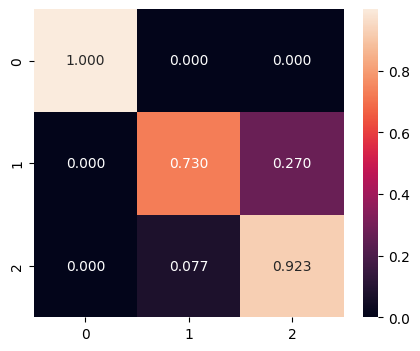

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


A Jupyter Widget

[[325592    107     21]
 [     3 599112 210390]
 [     0    652   4859]]


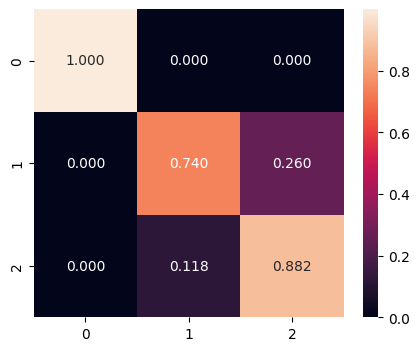

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


A Jupyter Widget

[[51591154    12211     2651]
 [     207 91210373 16399362]
 [       0      167      515]]


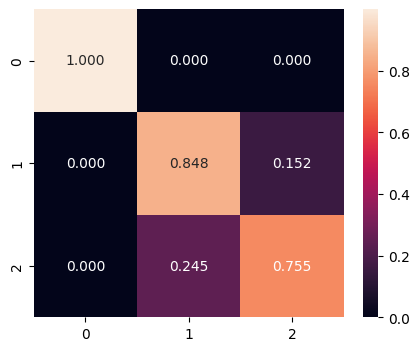

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kalexis/.local/share/virtualenvs/mlfires_private-NKUXObPR/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/kalexis/mlfires_private/version6/ckpts exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type                      | Params
------------------------------------------------------
0 | net     | UNet                      | 31.1 M
1 | confmat | MulticlassConfusionMatrix | 0     
------------------------------------------------------
31.1 M    Trainable params
0         Non-trainable params
31.1 M    Total params
124.287   Total estimated model params size (MB)


    train result: [{'test_loss': 0.2551840841770172, 'test_precision_0': 0.9999929101144307, 'test_precision_1': 0.9991980151311306, 'test_precision_2': 0.019018402064961006, 'test_recall_0': 0.999591786402235, 'test_recall_1': 0.729863445183761, 'test_recall_2': 0.9226618705035972, 'test_hybrid1': 0.8150158610615229, 'test_hybrid2': 0.8479940586596966, 'test_hybrid5': 0.8837536095548658, 'test_nh1': 1.6525253156873583, 'test_nh2': 2.575187186190955, 'test_nh5': 5.3431727977017465, 'test_nh10': 9.956482150219733}]
    val result: [{'test_loss': 0.2893654704093933, 'test_precision_0': 0.9999907860992951, 'test_precision_1': 0.9987347279665127, 'test_precision_2': 0.02257165420170019, 'test_recall_0': 0.9996070244381677, 'test_recall_1': 0.7400967257768636, 'test_recall_2': 0.8816911631282889, 'test_hybrid1': 0.8047128079346555, 'test_hybrid2': 0.8288339814586916, 'test_hybrid5': 0.8544458986354344, 'test_nh1': 1.6217878889051525, 'test_nh2': 2.503479052033441, 'test_nh5': 5.148552541418

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Found pretrained model, loading from ckpts/semseg-fold02-epoch10-val_loss0.272.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


A Jupyter Widget

[[ 691299      13       9]
 [     60 1177278  402434]
 [      0     777    9602]]


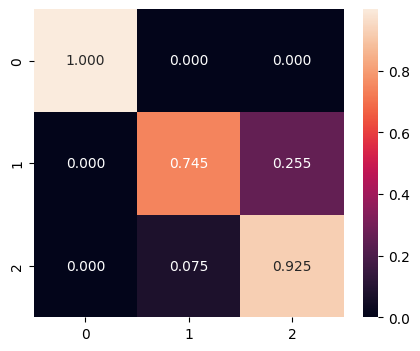

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


A Jupyter Widget

[[339895     12      5]
 [    57 600478 196261]
 [     0    545   3483]]


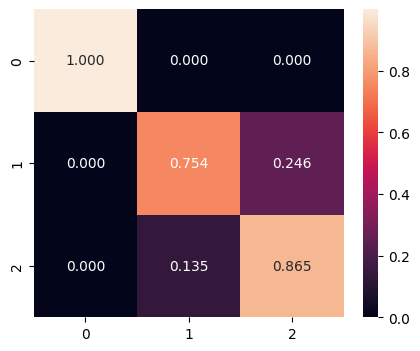

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


A Jupyter Widget

[[51604545     1263      208]
 [    3205 92900079 14706658]
 [       0      118      564]]


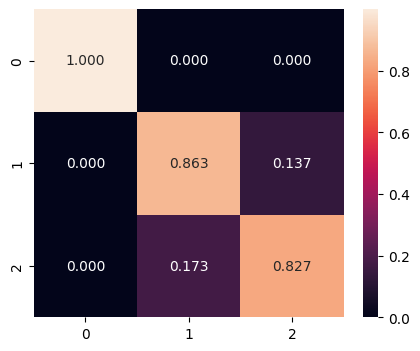

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type                      | Params
------------------------------------------------------
0 | net     | UNet                      | 31.1 M
1 | confmat | MulticlassConfusionMatrix | 0     
------------------------------------------------------
31.1 M    Trainable params
0         Non-trainable params
31.1 M    Total params
124.287   Total estimated model params size (MB)


    train result: [{'test_loss': 0.24329687654972076, 'test_precision_0': 0.999913214408144, 'test_precision_1': 0.9993294105263872, 'test_precision_2': 0.023303279981555413, 'test_recall_0': 0.9999681768671862, 'test_recall_1': 0.745220196332129, 'test_recall_2': 0.9251372964640139, 'test_hybrid1': 0.8254891550802035, 'test_hybrid2': 0.8562312039989338, 'test_hybrid5': 0.8893515530445717, 'test_nh1': 1.6703574927961429, 'test_nh2': 2.5954947892601568, 'test_nh5': 5.370906678652198, 'test_nh10': 9.996593160972267}]
    val result: [{'test_loss': 0.2718862295150757, 'test_precision_0': 0.9998323292700146, 'test_precision_1': 0.9990732652840517, 'test_precision_2': 0.017436883288527102, 'test_recall_0': 0.9999499870554732, 'test_recall_1': 0.7536157310026657, 'test_recall_2': 0.8646971201588878, 'test_hybrid1': 0.8053440987466854, 'test_hybrid2': 0.8242019054087905, 'test_hybrid5': 0.8439640301135222, 'test_nh1': 1.6183128511615534, 'test_nh2': 2.483009971320441, 'test_nh5': 5.0771013317

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Found pretrained model, loading from ckpts/semseg-fold03-epoch08-val_loss0.281.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


A Jupyter Widget

[[ 665564      53      15]
 [     72 1185696  420533]
 [      0     738    8801]]


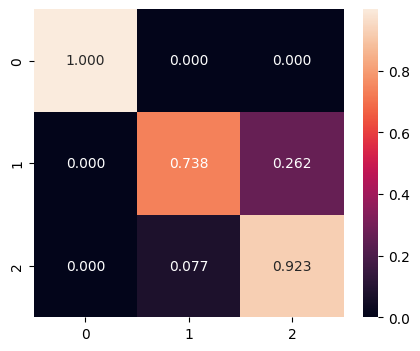

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


A Jupyter Widget

[[365574     20      7]
 [    19 563684 206564]
 [     0    623   4245]]


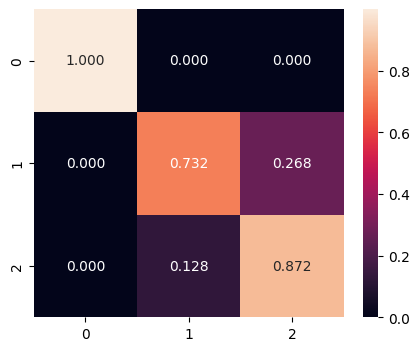

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


A Jupyter Widget

[[51601165     4386      465]
 [    3572 92608567 14997803]
 [       0      148      534]]


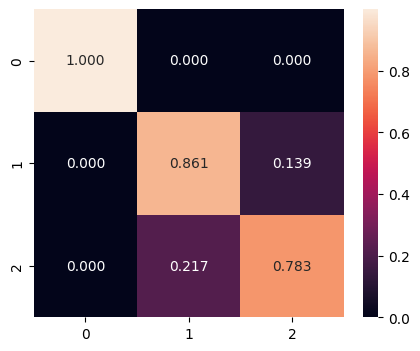

    train result: [{'test_loss': 0.2559930980205536, 'test_precision_0': 0.9998918327734678, 'test_precision_1': 0.9993333260288566, 'test_precision_2': 0.02049847559910469, 'test_recall_0': 0.9998978414499303, 'test_recall_1': 0.7381530609767409, 'test_recall_2': 0.9226333997274347, 'test_hybrid1': 0.8201471824131069, 'test_hybrid2': 0.8516821645728451, 'test_hybrid5': 0.8857391850664957, 'test_nh1': 1.6607864607041756, 'test_nh2': 2.5834198604316105, 'test_nh5': 5.351320059613914, 'test_nh10': 9.964487058251088}]
    val result: [{'test_loss': 0.28134584426879883, 'test_precision_0': 0.9999480296395171, 'test_precision_1': 0.9988605896935642, 'test_precision_2': 0.02013604280510018, 'test_recall_0': 0.9999261489984984, 'test_recall_1': 0.7318033876564879, 'test_recall_2': 0.8720213640098603, 'test_hybrid1': 0.795782940284743, 'test_hybrid2': 0.8196701061448902, 'test_hybrid5': 0.8450357013778514, 'test_nh1': 1.6038247516663482, 'test_nh2': 2.4758461156762084, 'test_nh5': 5.0919102077

In [8]:
train_df_ = pd.read_csv(pathlib.Path(cfg["ds_version"], "train_tiles.csv"))
test_df = pd.read_csv(pathlib.Path(cfg["ds_version"], "test_tiles.csv"))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

results = []

# Split train data into train and validation sets without common days among them
for i, (train_index, test_index) in enumerate(GroupKFold(
    n_splits=cfg["n_splits"]).split(train_df_, groups=train_df_["date"])):
    print(f"Fold {i+1}:")
    train_df = train_df_.iloc[train_index].reset_index(drop=True)
    val_df = train_df_.iloc[test_index].reset_index(drop=True)

    model = SemSegmentModule(
        num_classes=cfg["num_classes"], input_channels=cfg["input_channels"],
        ignore_index=cfg["ignore_index"], weight=class_weight, lr=cfg["lr"],
        monitor=cfg["monitor"], mode=cfg["mode"]
    )
    dm = SemSegmentDataModule(dataframes=[train_df, val_df, test_df],
                              root_dir=cfg["root_dir"], expand_fires=cfg[
                                  "expand_fires"],
                              batch_size=cfg["batch_size"], num_workers=cfg[
                                  "num_workers"])

    trainer = pl.Trainer(
        accelerator="auto",
        devices=1 if torch.cuda.is_available() else None,
        max_epochs=cfg["max_epochs"],
        callbacks=[
            EarlyStopping(monitor=cfg["monitor"], patience=cfg["patience"],
                          mode=cfg["mode"]),
            ModelCheckpoint(
                monitor=cfg["monitor"], mode=cfg["mode"], dirpath="ckpts/",
                filename=f'semseg-fold{i+1:02d}' + '-epoch{epoch:02d}-val_loss{val_loss:.3f}',
                auto_insert_metric_name=False),
            LearningRateMonitor("epoch")
        ],
    )
    trainer.logger._default_hp_metric = None
    trainer.fit(model, datamodule=dm)

    pretrained_filename = list(pathlib.Path("ckpts/").glob(
        f"semseg-fold{i+1:02d}*.ckpt"))[0]
    if pretrained_filename.is_file():
        print(f"Found pretrained model, loading from {pretrained_filename}")
        model = SemSegmentModule.load_from_checkpoint(pretrained_filename)
    else:
        print("Cannot find pretrained model!")

    train_result = trainer.test(model, dataloaders=dm.train_dataloader(),
                                verbose=False)
    val_result = trainer.test(model, dataloaders=dm.val_dataloader(),
                              verbose=False)
    test_result = trainer.test(model, dataloaders=dm.test_dataloader(),
                               verbose=False)
    result = {"train": train_result, "val": val_result, "test": test_result}

    results.append(result)
    for k, v in result.items():
        print(f"    {k} result: {v}")

Visualize how the predictions look like

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


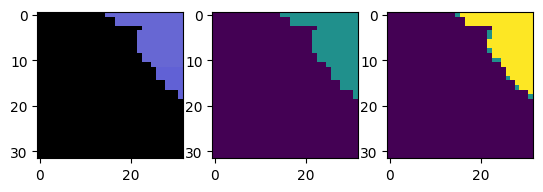

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


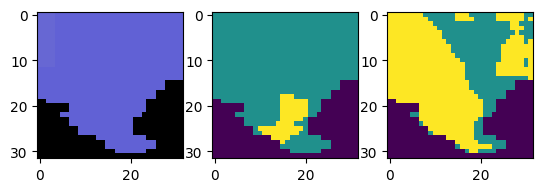

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


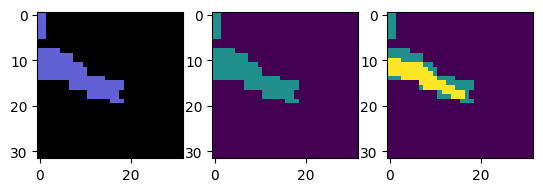

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


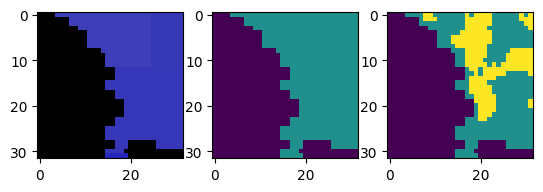

In [9]:
def get_test_samples(num):
    imgs, masks = list(zip(*[test_dataset_[i+938] for i in range(num)]))
    return torch.stack(imgs), torch.stack(masks)

def visualize_predictions(model, input_imgs, input_masks):
    model.eval()
    with torch.no_grad():
        pred_imgs = model(input_imgs.float().to(model.device))
    pred_imgs = pred_imgs.cpu()

    for img, mask, pred in zip(input_imgs, input_masks, pred_imgs):
        f, ax = plt.subplots(1, 3)
        ax[0].imshow(torch.moveaxis(img, 0, 2)[:, :, :3])
        ax[1].imshow(mask, vmin=0, vmax=2)
        ax[2].imshow(torch.argmax(pred, axis=0), vmin=0, vmax=2)
        plt.show()


input_imgs, input_masks = get_test_samples(4)
visualize_predictions(model, input_imgs, input_masks)

Collect and aggregate results for train, val and test sets

In [10]:
def show_evaluation_metrics(results, dataset="train"):
    res = pd.json_normalize(results, dataset)
    res = res.rename(lambda x: x[len("test_"):], axis='columns')
    res = pd.concat([res, res.apply(['mean', 'std'])])
    return res

show_evaluation_metrics(results, dataset="train")

,loss,precision_0,precision_1,precision_2,recall_0,recall_1,recall_2,hybrid1,hybrid2,hybrid5,nh1,nh2,nh5,nh10
0,0.255184,0.999993,0.999198,0.019018,0.999592,0.729863,0.922662,0.815016,0.847994,0.883754,1.652525,2.575187,5.343173,9.956482
1,0.243297,0.999913,0.999329,0.023303,0.999968,0.745220,0.925137,0.825489,0.856231,0.889352,1.670357,2.595495,5.370907,9.996593
2,0.255993,0.999892,0.999333,0.020498,0.999898,0.738153,0.922633,0.820147,0.851682,0.885739,1.660786,2.583420,5.351320,9.964487
mean,0.251491,0.999933,0.999287,0.020940,0.999819,0.737746,0.923478,0.820217,0.851969,0.886281,1.661223,2.584701,5.355133,9.972521
std,0.007108,0.000053,0.000077,0.002176,0.000200,0.007686,0.001437,0.005237,0.004126,0.002838,0.008924,0.010214,0.014255,0.021228


In [11]:
show_evaluation_metrics(results, dataset="val")

,loss,precision_0,precision_1,precision_2,recall_0,recall_1,recall_2,hybrid1,hybrid2,hybrid5,nh1,nh2,nh5,nh10
0,0.289365,0.999991,0.998735,0.022572,0.999607,0.740097,0.881691,0.804713,0.828834,0.854446,1.621788,2.503479,5.148553,9.557008
1,0.271886,0.999832,0.999073,0.017437,0.999950,0.753616,0.864697,0.805344,0.824202,0.843964,1.618313,2.483010,5.077101,9.400587
2,0.281346,0.999948,0.998861,0.020136,0.999926,0.731803,0.872021,0.795783,0.819670,0.845036,1.603825,2.475846,5.091910,9.452017
mean,0.280866,0.999924,0.998890,0.020048,0.999828,0.741839,0.872803,0.801947,0.824235,0.847815,1.614642,2.487445,5.105855,9.469871
std,0.008750,0.000082,0.000171,0.002569,0.000191,0.011010,0.008524,0.005347,0.004582,0.005767,0.009528,0.014340,0.037711,0.079724


In [12]:
show_evaluation_metrics(results, dataset="test")

,loss,precision_0,precision_1,precision_2,recall_0,recall_1,recall_2,hybrid1,hybrid2,hybrid5,nh1,nh2,nh5,nh10
0,0.127631,0.999996,0.999864,0.000031,0.999712,0.847602,0.755132,0.798699,0.783629,0.769117,1.602734,2.357866,4.623262,8.398921
1,0.113742,0.999938,0.999985,0.000038,0.999971,0.863304,0.826979,0.844751,0.838743,0.832820,1.690283,2.517263,4.998201,9.133099
2,0.121419,0.999931,0.999951,0.000036,0.999906,0.860595,0.782991,0.819961,0.807256,0.794938,1.643586,2.426577,4.775551,8.690507
mean,0.120931,0.999955,0.999933,0.000035,0.999863,0.857167,0.788368,0.821137,0.809876,0.798958,1.645534,2.433902,4.799005,8.740842
std,0.006957,0.000036,0.000062,0.000004,0.000135,0.008394,0.036224,0.023049,0.027650,0.032041,0.043807,0.079951,0.188567,0.369668
